## K-Means Algorithm Implementation

In [3]:
# Add Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans as SklearnKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [4]:
dataset_path = "./../datasets"

iris_dataset_path = dataset_path + "/iris.csv"                                         
ai_global_index_path = dataset_path + "/AI_index_db.csv"
global_earthquake_data_path = dataset_path + "/earthquakes.csv"


In [5]:
iris_df = pd.read_csv(iris_dataset_path)
ai_global_index_df = pd.read_csv(ai_global_index_path)
global_earthquake_data_df = pd.read_csv(global_earthquake_data_path)

datasets = {
    "iris": iris_df,
    "ai_global_index": ai_global_index_df,
    "global_earthquake": global_earthquake_data_df
}

In [6]:
# Custom K-Means Implementation
class CustomKMeans:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.labels_ = None

    def fit(self, X):
        n_samples, n_features = X.shape
        self.centroids = X[np.random.choice(n_samples, self.n_clusters, replace=False)]

        for iteration in range(self.max_iter):
            # Assign clusters
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            self.labels_ = np.argmin(distances, axis=1)

            # Update centroids
            new_centroids = np.array([X[self.labels_ == i].mean(axis=0) for i in range(self.n_clusters)])

            # Check for convergence
            if np.allclose(self.centroids, new_centroids, atol=self.tol):
                break

            self.centroids = new_centroids

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

In [7]:
# Function to evaluate clustering performance
def evaluate_clustering(X, labels):
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)
    return silhouette, davies_bouldin, calinski_harabasz


Processing iris dataset
Custom K-Means Metrics for iris:
Silhouette Score: 0.4584, Davies-Bouldin Index: 0.8358, Calinski-Harabasz Index: 239.3361
Sklearn K-Means Metrics for iris:
Silhouette Score: 0.4787, Davies-Bouldin Index: 0.7868, Calinski-Harabasz Index: 156.1430


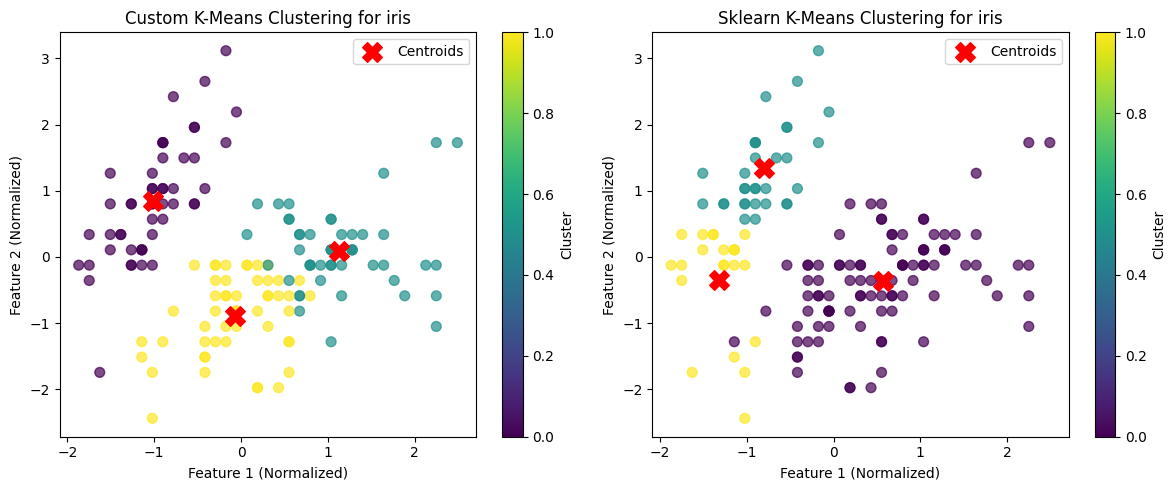


Processing ai_global_index dataset
Custom K-Means Metrics for ai_global_index:
Silhouette Score: 0.3159, Davies-Bouldin Index: 0.9811, Calinski-Harabasz Index: 39.2425
Sklearn K-Means Metrics for ai_global_index:
Silhouette Score: 0.3028, Davies-Bouldin Index: 0.8218, Calinski-Harabasz Index: 37.9011


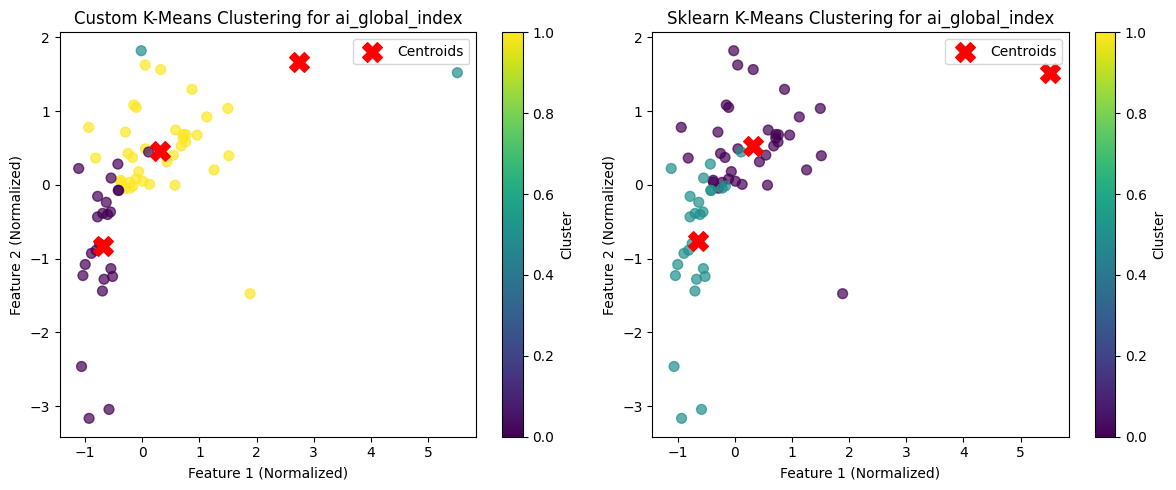


Processing global_earthquake dataset
Custom K-Means Metrics for global_earthquake:
Silhouette Score: 0.1958, Davies-Bouldin Index: 1.8174, Calinski-Harabasz Index: 12.3794
Sklearn K-Means Metrics for global_earthquake:
Silhouette Score: 0.2137, Davies-Bouldin Index: 1.6484, Calinski-Harabasz Index: 14.5256


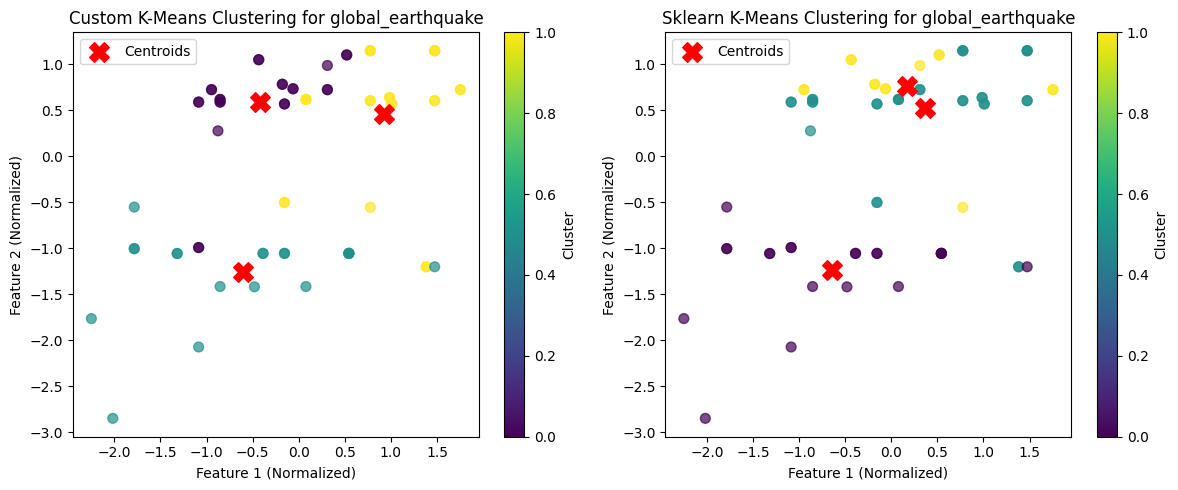

In [8]:
# Process datasets
results = {}

for name, df in datasets.items():
    print(f"\nProcessing {name} dataset")

    # Handle missing values
    df = df.dropna()  # or use df.fillna(df.mean(numeric_only=True))

    # Select only numeric columns
    X = df.select_dtypes(include=[np.number]).values

    # Normalize data
    X = StandardScaler().fit_transform(X)

    # Run custom K-Means
    custom_kmeans = CustomKMeans(n_clusters=3, max_iter=100, tol=1e-4)
    custom_kmeans.fit(X)
    custom_labels = custom_kmeans.labels_

    # Run sklearn K-Means
    sklearn_kmeans = SklearnKMeans(n_clusters=3, max_iter=100, tol=1e-4, random_state=42)
    sklearn_kmeans.fit(X)
    sklearn_labels = sklearn_kmeans.labels_

    # Evaluate clustering performance
    custom_metrics = evaluate_clustering(X, custom_labels)
    sklearn_metrics = evaluate_clustering(X, sklearn_labels)

    # Save results
    results[name] = {
        "custom_silhouette": custom_metrics[0],
        "custom_davies_bouldin": custom_metrics[1],
        "custom_calinski_harabasz": custom_metrics[2],
        "sklearn_silhouette": sklearn_metrics[0],
        "sklearn_davies_bouldin": sklearn_metrics[1],
        "sklearn_calinski_harabasz": sklearn_metrics[2]
    }
     # Print results
    print(f"Custom K-Means Metrics for {name}:")
    print(f"Silhouette Score: {custom_metrics[0]:.4f}, Davies-Bouldin Index: {custom_metrics[1]:.4f}, Calinski-Harabasz Index: {custom_metrics[2]:.4f}")
    print(f"Sklearn K-Means Metrics for {name}:")
    print(f"Silhouette Score: {sklearn_metrics[0]:.4f}, Davies-Bouldin Index: {sklearn_metrics[1]:.4f}, Calinski-Harabasz Index: {sklearn_metrics[2]:.4f}")

    # Visualize clusters
    plt.figure(figsize=(12, 5))

    # Plot Custom K-Means clusters
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=custom_labels, cmap="viridis", s=50, alpha=0.7)
    plt.scatter(custom_kmeans.centroids[:, 0], custom_kmeans.centroids[:, 1], c="red", marker="X", s=200, label="Centroids")
    plt.title(f"Custom K-Means Clustering for {name}")
    plt.xlabel("Feature 1 (Normalized)")
    plt.ylabel("Feature 2 (Normalized)")
    plt.legend()
    plt.colorbar(label="Cluster")

    # Plot Sklearn K-Means clusters
    plt.subplot(1, 2, 2)
    plt.scatter(X[:, 0], X[:, 1], c=sklearn_labels, cmap="viridis", s=50, alpha=0.7)
    plt.scatter(sklearn_kmeans.cluster_centers_[:, 0], sklearn_kmeans.cluster_centers_[:, 1], c="red", marker="X", s=200, label="Centroids")
    plt.title(f"Sklearn K-Means Clustering for {name}")
    plt.xlabel("Feature 1 (Normalized)")
    plt.ylabel("Feature 2 (Normalized)")
    plt.legend()
    plt.colorbar(label="Cluster")

    plt.tight_layout()
    plt.show()


In [9]:
results_df = pd.DataFrame(results)
results_df.to_csv("./../results/kmeans_result.csv")